In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

import pickle

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
X = pd.read_csv('training_set_values.csv', index_col = 0)

In [3]:
y = pd.read_csv('training_set_labels.csv', index_col = 0)

In [4]:
df = pd.concat([X, y], axis = 1)

In [5]:
classes = ['functional', 'functional needs repair', 'non functional']

#### remove: wpt_name, date_recorded, region_code, recorded_by, scheme_name, extraction_type, payment_type, water_quality, quantity_group, source

#### possibly to remove: funder, long/lat, num_private, installer, subvillage

#### Maybe: district_code, lga, ward, scheme_management/management, extraction_type_group, management_group

#### Dummies: Basin, region, public_meeting, permit, extraction_type_class, payment, quality_group, quantity, source_type, source_class, waterpoint_type_group

#### Continuous: amount_tsh, gps_height, population, construction_year (look at 0's)

In [6]:
df.drop(columns = ['wpt_name', 'date_recorded', 'region_code', 'recorded_by', 
                     'scheme_name', 'extraction_type', 'payment_type', 'water_quality', 
                     'quantity_group', 'source', 'waterpoint_type'], inplace = True)

In [7]:
df2 = df.drop(columns = ['funder', 'longitude', 'latitude', 'num_private', 
                         'installer', 'subvillage'])

In [8]:
df3 = df2.drop(columns = ['district_code', 'lga', 'ward', 'scheme_management', 'management', 
                          'extraction_type_group', 'management_group', 'construction_year'])

In [9]:
df3.dropna(inplace = True)

## Making Dummies

In [10]:
basin_dummies = pd.get_dummies(df3['basin'], prefix = 'basin_', drop_first = True)

region_dummies = pd.get_dummies(df3['region'], prefix = 'region_', drop_first = True)

extraction_dummies = pd.get_dummies(df3['extraction_type_class'], prefix = 'extraction_', 
                                    drop_first = True)

payment_dummies = pd.get_dummies(df3['payment'], prefix = 'payment_', drop_first = True)

quality_dummies = pd.get_dummies(df3['quality_group'], prefix = 'quality_', drop_first = True)

quantity_dummies = pd.get_dummies(df3['quantity'], prefix = 'quantity_', drop_first = True)

source_type_dummies = pd.get_dummies(df3['source_type'], prefix = 'source_type', 
                                     drop_first = True)

source_class_dummies = pd.get_dummies(df3['source_class'], prefix = 'source_class', 
                                      drop_first = True)

waterpoint_type_dummies = pd.get_dummies(df3['waterpoint_type_group'], prefix = 'waterpoint_type_',
                                       drop_first = True)

In [11]:
permit_dict = {True: 1,
               False: 0}

df3[['permit', 'public_meeting']] = df3[['permit', 'public_meeting']].replace(permit_dict)

In [12]:
status_dict = {'functional': 1, 
               'non functional': 0, 
               'functional needs repair': 2}

In [13]:
df3 = pd.concat([df3, waterpoint_type_dummies, source_class_dummies, source_type_dummies,
                basin_dummies, region_dummies, extraction_dummies, payment_dummies,
                quality_dummies, quantity_dummies], axis = 1)

In [14]:
df3.drop(columns = ['basin', 'region', 'extraction_type_class', 'payment', 'quality_group', 
                    'quantity', 'source_type', 'source_class', 'waterpoint_type_group'], inplace = True)

In [15]:
df3.columns

Index(['amount_tsh', 'gps_height', 'population', 'public_meeting', 'permit',
       'status_group', 'waterpoint_type__communal standpipe',
       'waterpoint_type__dam', 'waterpoint_type__hand pump',
       'waterpoint_type__improved spring', 'waterpoint_type__other',
       'source_class_surface', 'source_class_unknown', 'source_type_dam',
       'source_type_other', 'source_type_rainwater harvesting',
       'source_type_river/lake', 'source_type_shallow well',
       'source_type_spring', 'basin__Lake Nyasa', 'basin__Lake Rukwa',
       'basin__Lake Tanganyika', 'basin__Lake Victoria', 'basin__Pangani',
       'basin__Rufiji', 'basin__Ruvuma / Southern Coast', 'basin__Wami / Ruvu',
       'region__Dar es Salaam', 'region__Dodoma', 'region__Iringa',
       'region__Kagera', 'region__Kigoma', 'region__Kilimanjaro',
       'region__Lindi', 'region__Manyara', 'region__Mara', 'region__Mbeya',
       'region__Morogoro', 'region__Mtwara', 'region__Mwanza', 'region__Pwani',
       'region__

In [16]:
X3 = df3.drop(columns = ['status_group'], axis = 1)

In [17]:
y3 = df3['status_group']

In [18]:
y3.unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

## Basic_Model

In [19]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=23)

In [20]:
scaler3 = StandardScaler()
scaler3.fit(X3_train)
X3_train = pd.DataFrame(data=scaler3.transform(X3_train), columns = X3.columns)
X3_test = pd.DataFrame(data=scaler3.transform(X3_test), columns = X3.columns)

## KNN Model (Basic Set #1)

In [21]:
knn_df3 = KNeighborsClassifier()

In [22]:
knn_df3.fit(X3_train, y3_train)

y_pred_knn3 = knn_df3.predict(X3_test)
y_train_knn3 = knn_df3.predict(X3_train)

In [23]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_knn3))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_knn3))

Test Accuracy score:  0.747466406425944
Train Accuracy score:  0.8002752752752753


In [351]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[6091  222  880]
 [ 581  247  145]
 [1423  113 3619]]


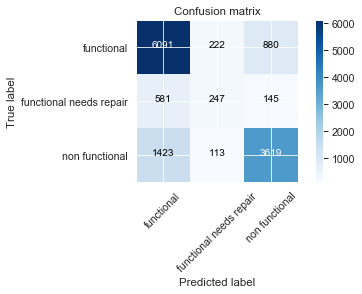

In [364]:
plot_confusion_matrix(metrics.confusion_matrix(y3_test, y_pred_knn3), classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Random Forest (Best set #2)

In [391]:
rfc_df3 = RandomForestClassifier(class_weight='balanced', criterion = 'entropy', max_depth =15, 
                                 n_estimators = 200, random_state = 23, n_jobs = -1)

In [392]:
rfc_df3.fit(X3_train, y3_train)

y_pred_rfc3 = rfc_df3.predict(X3_test)
y_train_rfc3 = rfc_df3.predict(X3_train)

In [393]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y3_test, y_pred_rfc3))

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y3_train, y_train_rfc3))

Test Accuracy score:  0.7149613392387959
Train Accuracy score:  0.7802302302302302


### Random Forest Gridsearch 

In [384]:
params_df3 = {'max_depth': [3, 6, 9, 12, 15], 'n_estimators' : [100, 200, 300, 400, 500], 
              'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 4, 6], 
              'criterion': ['gini', 'entropy']} 

In [387]:
grid_df3 = GridSearchCV(rfc_df3, params_df3, verbose = 1, n_jobs = -1, cv = 5, scoring = 'accuracy')

grid_df3.fit(X3_train, y3_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed: 46.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=23,
                              

In [390]:
grid_df3.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)